In [64]:
import propagators
import energy_landscapes
import energy_landscapes_gaussian
import long_simulation
import weighted_ensemble_3
import numpy as np
import MSM_methods
import analysis
import metadynamics

import matplotlib.pyplot as plt
import importlib

#methods for fast print debugging
def p(x):
    print(x)
def pl(x):
    print(len(x))
def ps(x):
    print(x.shape)

kT = 1
dt = 0.001
n_analysis_bins = 50
save_period = 100 #in steps
aggregate_simulation_limit = 500000
#nsteps = 100000
n_parallel = 10
n_bootstrap = 3

# system1 = energy_landscapes.unit_double_well()
# system1.plot_quantity(system1.potential)
# system1.plot_quantity(system1.F)
#system1.analysis_bins(40)


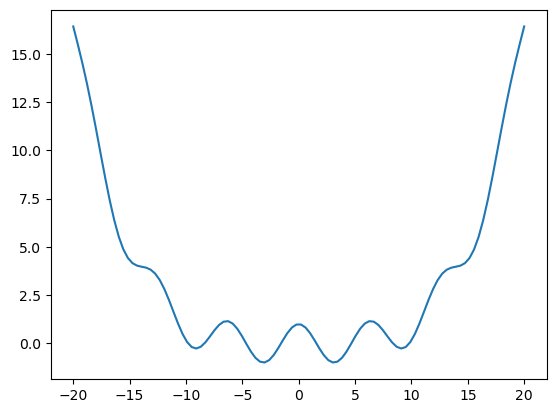

<function long_simulation_histogram_analysis_mtd at 0x7ff671f6ec20>
round 0


/Users/jonathanborowsky/Documents/grabelab/methods-development/sampling-methods/long_simulation.py:177: RuntimeWarning: divide by zero encountered in reciprocal
  mfpts = save_period*np.reciprocal(n_transitions)*frames_by_state
/Users/jonathanborowsky/Documents/grabelab/methods-development/sampling-methods/long_simulation.py:177: RuntimeWarning: invalid value encountered in multiply
  mfpts = save_period*np.reciprocal(n_transitions)*frames_by_state


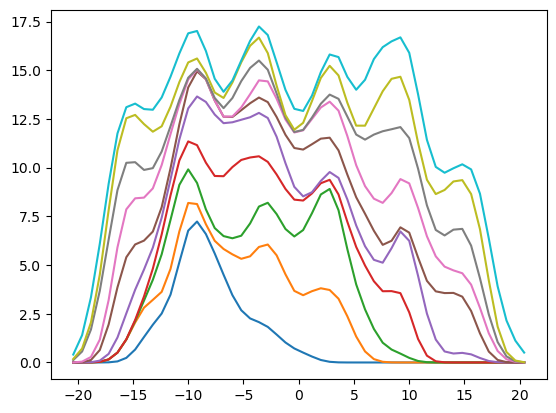

round 1


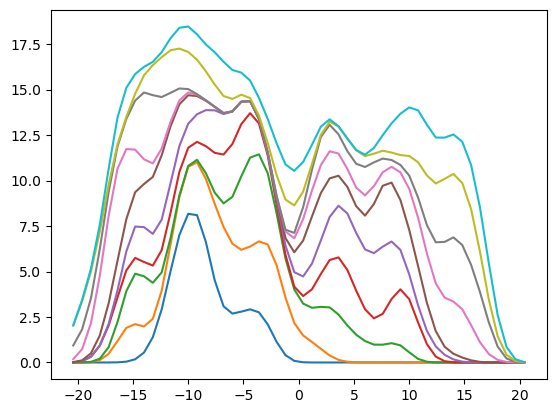

round 2


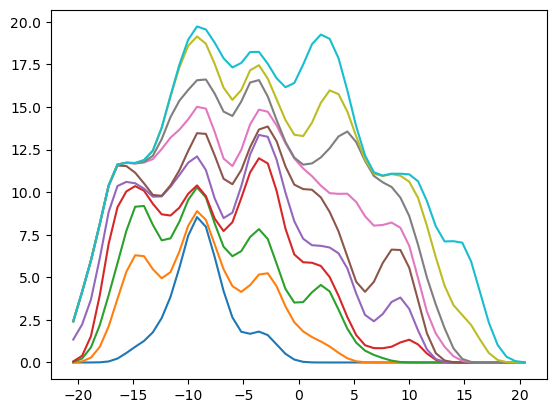

/opt/anaconda3/envs/grabelab/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


<function long_simulation_msm_analysis at 0x7ff671f6e440>
round 0
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
round 1
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvector converged to within 10^-12 after 0 rounds
eigenvec

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 0 is different from 1)

In [65]:
importlib.reload(analysis)
importlib.reload(long_simulation)
importlib.reload(weighted_ensemble_3)
importlib.reload(propagators)
importlib.reload(energy_landscapes_gaussian)
importlib.reload(energy_landscapes)
importlib.reload(MSM_methods)
importlib.reload(metadynamics)

system1 = energy_landscapes.unit_sine_well()
system1.plot_quantity(system1.potential)
plt.show()


#long_simulation.long_simulation_histogram_analysis, long_simulation.long_simulation_hamsm_analysis, weighted_ensemble_2.weighted_ensemble_hamsm_analysis
mfpts_all, populations_all, agg_t_maew_all = analysis.bootstrap_method_comparison(
    3, 
    [long_simulation.long_simulation_histogram_analysis_mtd, 
     long_simulation.long_simulation_msm_analysis, 
     weighted_ensemble_3.weighted_ensemble_msm_analysis], 
     system1, kT, dt, 
     aggregate_simulation_limit, n_parallel, save_period, 
     n_analysis_bins, n_timepoints=10)

analysis.plot_bootstrapping_results(populations_all, system1, kT, n_analysis_bins)
plt.show()
analysis.plot_convergence(agg_t_maew_all)
plt.show()

#TODO implement MFPT comparison
#TODO fast synthetic trajectories
#TODO compare MSMs built with and without weights